In [1]:
import pandas as pd
import numpy as np

In [2]:
users = pd.read_csv("Users.csv")
ratings = pd.read_csv("Ratings.csv")
books = pd.read_csv("Books.csv")

C:\Users\juana\AppData\Local\Temp\ipykernel_25828\826114351.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


In [3]:
df = pd.merge(pd.merge(ratings, users, on='User-ID'), books, on='ISBN')
len(df)

1031136

In [4]:
df.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [5]:
books_count = df.groupby("ISBN", as_index=False)[["User-ID"]].count().rename(columns={"User-ID": "book_count"})
users_count = df.groupby("User-ID", as_index=False)[["ISBN"]].count().rename(columns={"ISBN": "user_count"})
filtered_data = df.merge(books_count, on="ISBN").merge(users_count, on="User-ID")
filtered_data = filtered_data[(filtered_data.book_count >= 20) & (filtered_data.user_count >= 20)]
len(filtered_data)

284030

In [6]:
filtered_data["Book-Rating"].value_counts()

Book-Rating
0     192894
8      22393
10     18661
9      16482
7      14936
5       8710
6       6736
4       1469
3        963
2        494
1        292
Name: count, dtype: int64

In [7]:
filtered_data.dtypes

User-ID                  int64
ISBN                    object
Book-Rating              int64
Location                object
Age                    float64
Book-Title              object
Book-Author             object
Year-Of-Publication     object
Publisher               object
Image-URL-S             object
Image-URL-M             object
Image-URL-L             object
book_count               int64
user_count               int64
dtype: object

In [8]:
filtered_data['ISBN'] = pd.Categorical(filtered_data['ISBN'])
filtered_data['ISBN'] = filtered_data['ISBN'].cat.codes

filtered_data['User-ID'] = pd.Categorical(filtered_data['User-ID'])
filtered_data['User-ID'] = filtered_data['User-ID'].cat.codes

In [9]:
rating_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 1,
    9: 2,
    10: 2
}

filtered_data["Book-Rating-NPS"] = filtered_data["Book-Rating"].map(rating_map)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [11]:
filtered_data["Book-Rating"] = pd.cut(filtered_data["Book-Rating"], bins=11, labels=list(range(11)))
filtered_data["Book-Rating-NPS"] = pd.cut(filtered_data["Book-Rating-NPS"], bins=3, labels=list(range(3)))
filtered_data = filtered_data.drop(['Image-URL-S','Image-URL-M', 'Image-URL-L'], axis=1)

In [12]:
filtered_data.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,book_count,user_count,Book-Rating-NPS
1,44,1498,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60,36,0
2,44,6557,9,"cincinnati, ohio, usa",23.0,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,23,36,2
3,44,5868,8,"cincinnati, ohio, usa",23.0,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,55,36,1
4,44,76,9,"cincinnati, ohio, usa",23.0,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,130,36,2
5,44,2283,5,"cincinnati, ohio, usa",23.0,The Mistress of Spices,Chitra Banerjee Divakaruni,1998,Anchor Books/Doubleday,80,36,0


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is the merged DataFrame

# Select relevant columns for features and target
features = ["User-ID","ISBN","Location","Age","Book-Title","Book-Author","Year-Of-Publication","Publisher","book_count","user_count"]
target = 'Book-Rating-NPS'

# Encoding categorical features
label_encoders = {}
for feature in features:
    if filtered_data[feature].dtype == 'object':
        label_encoders[feature] = LabelEncoder()
        filtered_data[feature] = label_encoders[feature].fit_transform(filtered_data[feature])

# Splitting data into train and test sets
X = filtered_data[features]
y = filtered_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


num_books = filtered_data['Book-Title'].nunique()  
embedding_dim = 50 

# Input for book matrix
book_input = Input(shape=(1,), name='book_input')
book_embedding = Embedding(input_dim=num_books, output_dim=embedding_dim, input_length=1)(book_input)
book_vec = Flatten()(book_embedding)

# Additional features input
other_input = Input(shape=(len(features),), name='other_input')

concatenated = Concatenate()([book_vec, other_input])

# Adding dense layers for prediction
x = Dense(128, activation='relu')(concatenated)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(11, activation='softmax')(x) 

# Creating the model
model = Model(inputs=[book_input, other_input], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Training the model
history = model.fit([X_train['Book-Title'], X_train[features]], y_train, epochs=2, batch_size=64, validation_split=0.2)
#validation_data=([X_test['Book-Title'], X_test[features]], y_test)

Epoch 1/2
2841/2841 [==============================] - 13s 4ms/step - loss: nan - accuracy: 0.7454 - val_loss: nan - val_accuracy: 0.7417
Epoch 2/2
2841/2841 [==============================] - 18s 6ms/step - loss: nan - accuracy: 0.7455 - val_loss: nan - val_accuracy: 0.7417


## Estructura de la red:

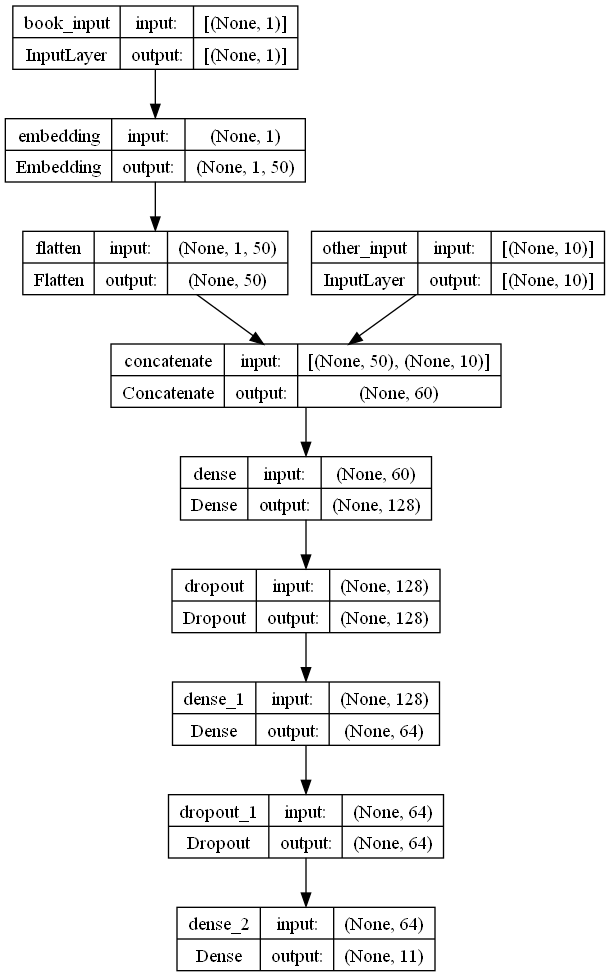

In [17]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is the neural network model created previously

# Plot the model architecture
plot_model(model, to_file='neural_network_plot.png', show_shapes=True, show_layer_names=True)

1776/1776 [==============================] - 2s 994us/step


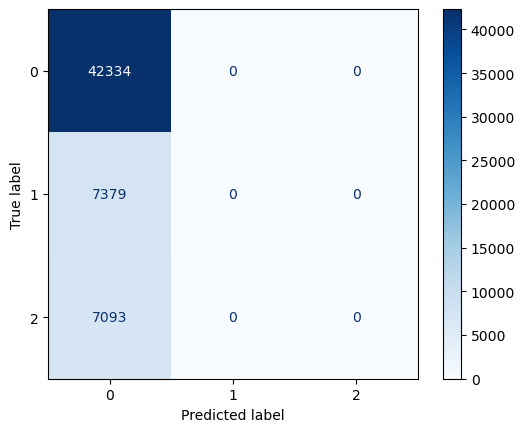

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#y_pred = model.predict([X_test['Book-Title'], X_test[features]], y_test)
predictions_1 = np.argmax(model.predict([X_test['Book-Title'], X_test[features]]), axis=1)

ConfusionMatrixDisplay.from_predictions(y_test, predictions_1, cmap='Blues')
plt.show()